In [36]:
!pip install -q -U "neptune[lightgbm]" "neptune[optuna]" graphviz

In [37]:
# Importing the Libraries
import neptune
import optuna
from neptune.integrations.lightgbm import (
    NeptuneCallback, create_booster_summary
)
import neptune.integrations.optuna as npt_utils
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from functools import partial
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score,classification_report

In [38]:
NEPTUNE_API_TOKEN = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyZjY2ZTI4Yy0xZTNlLTQ4NWMtYmNmOC1iYjVkMmIzNmViZmQifQ=="
PROJECT_NAME = "Light-GBM/CustomerLoyalty"

# **LOADING PROCESSED DATASET**

---




In [39]:
# Loading the dataset
df = pd.read_csv('https://raw.githubusercontent.com/nhanna1219/Closely_Customer_Classification/main/Preprocessed_Data.csv', sep=',')
print("Number of datapoints:", len(df))
df.head()

Number of datapoints: 2213


PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  5.368107 -1.804778 -1.078759 -0.646435 -3.097021  0.337949  0.007753   
1 -3.491633  0.502507 -0.427520 -0.183056  0.859958 -0.916708  2.148626   
2  2.018019 -1.291695 -1.182698 -1.128659  0.603602 -0.583301 -0.137928   
3 -3.286131  0.555640 -0.593547 -0.890906  0.937647  0.370995 -0.325239   
4 -0.585539 -1.463671  0.526403  2.031741  0.218226  0.454320 -0.106105   

        PC8       PC9      PC10  ...      PC14      PC15      PC16      PC17  \
0  0.821314 -0.411286  0.355576  ...  0.493904  0.814431 -0.774570  0.656888   
1  0.386522 -0.610815  1.025348  ...  0.453972 -0.146679  0.185969  0.007899   
2 -0.128718 -0.429963  0.473263  ... -1.240771  0.170181 -0.554964 -0.661380   
3  0.343596 -0.994986 -0.007917  ... -0.242170  0.251216 -0.071301 -0.027513   
4 -0.749205  0.098400 -0.308995  ...  0.156086  0.973668 -0.445877  0.238192   

       PC18      PC19      PC20      PC21  Loyalty_Score  Is_Loyal  
0  0.502650  0.688828 -1.420569  0.749187       0.405501      True  
1 -0.298426 -0.227511 -0.257056  0.167572       0.190314     False  
2  0.382996  0.297692  0.214487 -0.410894       0.380150      True  
3  0.068979  0.056725 -0.360599 -0.198887       0.234560     False  
4  0.781415 -0.038416 -0.242535 -0.114447       0.161950     False  

[5 rows x 23 columns]

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2213 entries, 0 to 2212
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PC1            2213 non-null   float64
 1   PC2            2213 non-null   float64
 2   PC3            2213 non-null   float64
 3   PC4            2213 non-null   float64
 4   PC5            2213 non-null   float64
 5   PC6            2213 non-null   float64
 6   PC7            2213 non-null   float64
 7   PC8            2213 non-null   float64
 8   PC9            2213 non-null   float64
 9   PC10           2213 non-null   float64
 10  PC11           2213 non-null   float64
 11  PC12           2213 non-null   float64
 12  PC13           2213 non-null   float64
 13  PC14           2213 non-null   float64
 14  PC15           2213 non-null   float64
 15  PC16           2213 non-null   float64
 16  PC17           2213 non-null   float64
 17  PC18           2213 non-null   float64
 18  PC19    

In [41]:
# Change "True" "False" label to 1, 0 respectively
df['Is_Loyal'] = df['Is_Loyal'].astype(int)

# Splitting the dataset into features and target variable
X = df.drop(['Loyalty_Score','Is_Loyal'], axis=1)
y = df['Is_Loyal']

In [42]:
# Used In study.optimize
def objective(trial, test_size, val_size):
  df = pd.read_csv('https://raw.githubusercontent.com/nhanna1219/Closely_Customer_Classification/main/Preprocessed_Data.csv', sep=',')
  # Splitting the data into training and testing sets
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=42)
  X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=val_size, random_state=42)

  dtrain = lgb.Dataset(X_train, label=y_train)
  dvalid = lgb.Dataset(X_val, label=y_val, reference=dtrain)
  param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
  }

  # pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "binary_logloss")
  # gbm = lgb.train(param, dtrain, valid_sets=[dvalid], callbacks=[pruning_callback])
  gbm = lgb.train(param,dtrain,valid_sets=[dtrain,dvalid])

  preds = gbm.predict(X_test,num_iteration=gbm.best_iteration)
  binary_preds = (preds > 0.5).astype(int)
  # Calculate log loss
  logloss = log_loss(y_test, preds)
  accuracy = accuracy_score(y_test, binary_preds)
  return logloss, accuracy

In [43]:
# Used In study.optimize !WITHOUT OPTUNA
def TrainLightGBM(dataset, params, test_size, val_size, isPredTest=True):
  params["objective"] = "binary"
  params["metric"] = "binary_logloss"
  params["max_bin"] = 32 # Avoid Overfitting
  params["max_depth"] = 7 # Avoid Overfitting

  # Train the model
  df = pd.read_csv(dataset, sep=',')
  # Splitting the data into training and testing sets
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=42)
  X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=val_size, random_state=42)

  run = neptune.init_run(
    project= PROJECT_NAME,
    api_token= NEPTUNE_API_TOKEN,
    name="train-cls",
    tags=["lgbm-integration", "train", "cls", "notebook"],
  )
  neptune_callback = NeptuneCallback(run=run)

  dtrain = lgb.Dataset(X_train, label=y_train)
  dvalid = lgb.Dataset(X_val, label=y_val, reference=dtrain)
  gbm = lgb.train(params,dtrain,valid_sets=[dtrain,dvalid],callbacks=[neptune_callback])

  if isPredTest == True:
    # Classify Test Set
    y_pred = gbm.predict(X_test,num_iteration=gbm.best_iteration)
    binary_pred= (y_pred > 0.5).astype(int)
    y_true = y_test
  else:
    # Classify Val Set
    y_pred = gbm.predict(X_val,num_iteration=gbm.best_iteration)
    binary_pred = (y_pred > 0.5).astype(int)
    y_true = y_val

  # Log summary metadata to the same run under the "lgbm_summary" namespace
  run["lgbm_summary"] = create_booster_summary(
      booster=gbm,
      log_trees=True,
      list_trees=[gbm.best_iteration],
      log_confusion_matrix=True,
      y_pred=binary_pred,
      y_true=y_true,
  )
  fileName = ''
  if test_size == 0.2:
    fileName = 'model_7-2-1'
  else:
    fileName = 'model_8-1-1'
  gbm.save_model(fileName)
  run.stop()

  return y_true, binary_pred

In [44]:
# Used to Compare Values of Metrics to Get Better Params choosen
def GetBestTrials(trial_ids):
    for trial_id in trial_ids:
        # Initialize a "Best" existing Neptune run
        run = neptune.init_run(
            with_id= trial_id,
            project= PROJECT_NAME,
            api_token= NEPTUNE_API_TOKEN,
        )

        # Load Optuna study from the Neptune Run
        study = npt_utils.load_study_from_run(run)

        best_trial = max(study.best_trials, key=lambda t: t.number)
        print("\n-----------------------------------")
        print(f"Trial ID: {trial_id}")
        print(f"\tNumber: {best_trial.number}")
        print("\tParams:")
        for param_name, param_value in best_trial.params.items():
          print(f"\t\t{param_name}: {param_value}")

        print("\tValues:")
        for metric_name, metric_value in zip(study.directions, best_trial.values):
          print(f"\t\t{metric_name}: {metric_value}")
        if len(trial_ids) > 1:
          run.stop()
    return best_trial.params, study, run

# **7-2-1 DATASET**

>## ***1. Integrate with OPTUNA and Neptune to Find The Best Params For LightGBM***

In [45]:
# for i in range(3):
#   run = neptune.init_run(
#     project= PROJECT_NAME,
#     api_token= NEPTUNE_API_TOKEN,
#     name="train-cls",
#     tags=["lgbm-integration", "train", "cls", "notebook"],
#   )
#   neptune_callback = NeptuneCallback(run=run)

#   objective_7_2_1 = partial(objective, test_size=0.3, val_size=1/3)
#   neptune_callback = npt_utils.NeptuneCallback(run)
#   # study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="minimize")
#   study = optuna.create_study(directions=["minimize","maximize"])

#   study.optimize(objective_7_2_1, n_trials=200, show_progress_bar=True,callbacks=[neptune_callback])
#   run.stop()

In [46]:
# # Print Trials Information as Dataframe
# study.trials_dataframe()

In [47]:
trials_to_compare = ["CUS-101", "CUS-102", "CUS-103"]
GetBestTrials(trials_to_compare)

https://app.neptune.ai/Light-GBM/CustomerLoyalty/e/CUS-101

-----------------------------------
Trial ID: CUS-101
	Number: 171
	Params:
		lambda_l1: 0.0003532429702531038
		lambda_l2: 0.11814096753454911
		num_leaves: 150
		feature_fraction: 0.7647576266493856
		bagging_fraction: 0.5508257449259144
		bagging_freq: 5
		min_child_samples: 34
	Values:
		1: 0.09484529538997467
		2: 0.964824120603015
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/Light-GBM/CustomerLoyalty/e/CUS-101/metadata
https://app.neptune.ai/Light-GBM/CustomerLoyalty/e/CUS-102

-----------------------------------
Trial ID: CUS-102
	Number: 165
	Params:
		lambda_l1: 3.855687263896626e-05
		lambda_l2: 0.0028187531556400796
		num_leaves: 19
		feature_fraction: 0.9550345842654697
		bagging_fraction: 0.8671093849677487
		bagging_freq: 1
		min_child_samples: 17
	Values:
		1: 0.08867207185093516
		2: 0.96

({'lambda_l1': 0.03015851719390966,
  'lambda_l2': 0.007163877422760625,
  'num_leaves': 227,
  'feature_fraction': 0.9061136077967191,
  'bagging_fraction': 0.5715726506449885,
  'bagging_freq': 3,
  'min_child_samples': 27},
 <neptune.metadata_containers.run.Run at 0x7bc5c3f0dd50>)

> **Pick CUS-103 because it strikes the best balance between the two metrics.**


In [48]:
params, study, run = GetBestTrials(["CUS-103"])

https://app.neptune.ai/Light-GBM/CustomerLoyalty/e/CUS-103

-----------------------------------
Trial ID: CUS-103
	Number: 51
	Params:
		lambda_l1: 0.03015851719390966
		lambda_l2: 0.007163877422760625
		num_leaves: 227
		feature_fraction: 0.9061136077967191
		bagging_fraction: 0.5715726506449885
		bagging_freq: 3
		min_child_samples: 27
	Values:
		1: 0.0829110513404926
		2: 0.9673366834170855


In [49]:
# plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study, target = lambda t: t.values[0]) #  Metric: Log Loss

/usr/local/lib/python3.10/dist-packages/optuna/visualization/_utils.py:67: UserWarning:

`target` is specified, but `target_name` is the default value, 'Objective Value'.



In [50]:
optuna.visualization.plot_optimization_history(study, target = lambda t: t.values[1]) #  Metric: Accuracy Score

In [51]:
# Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

In [52]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/Light-GBM/CustomerLoyalty/e/CUS-103/metadata


>## ***2. Train and classify using the best params pick from above and apply to LightGBM model***

https://app.neptune.ai/Light-GBM/CustomerLoyalty/e/CUS-142
[LightGBM] [Info] Number of positive: 778, number of negative: 771
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 1549, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502260 -> initscore=0.009038
[LightGBM] [Info] Start training from score 0.009038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

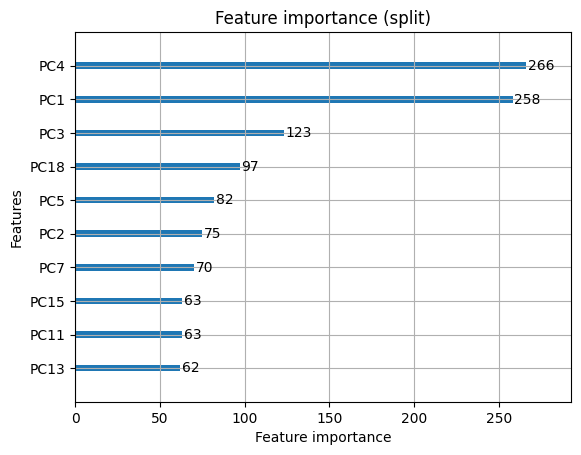

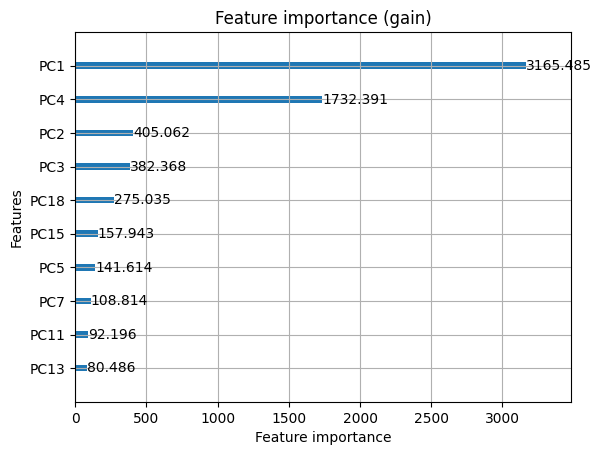

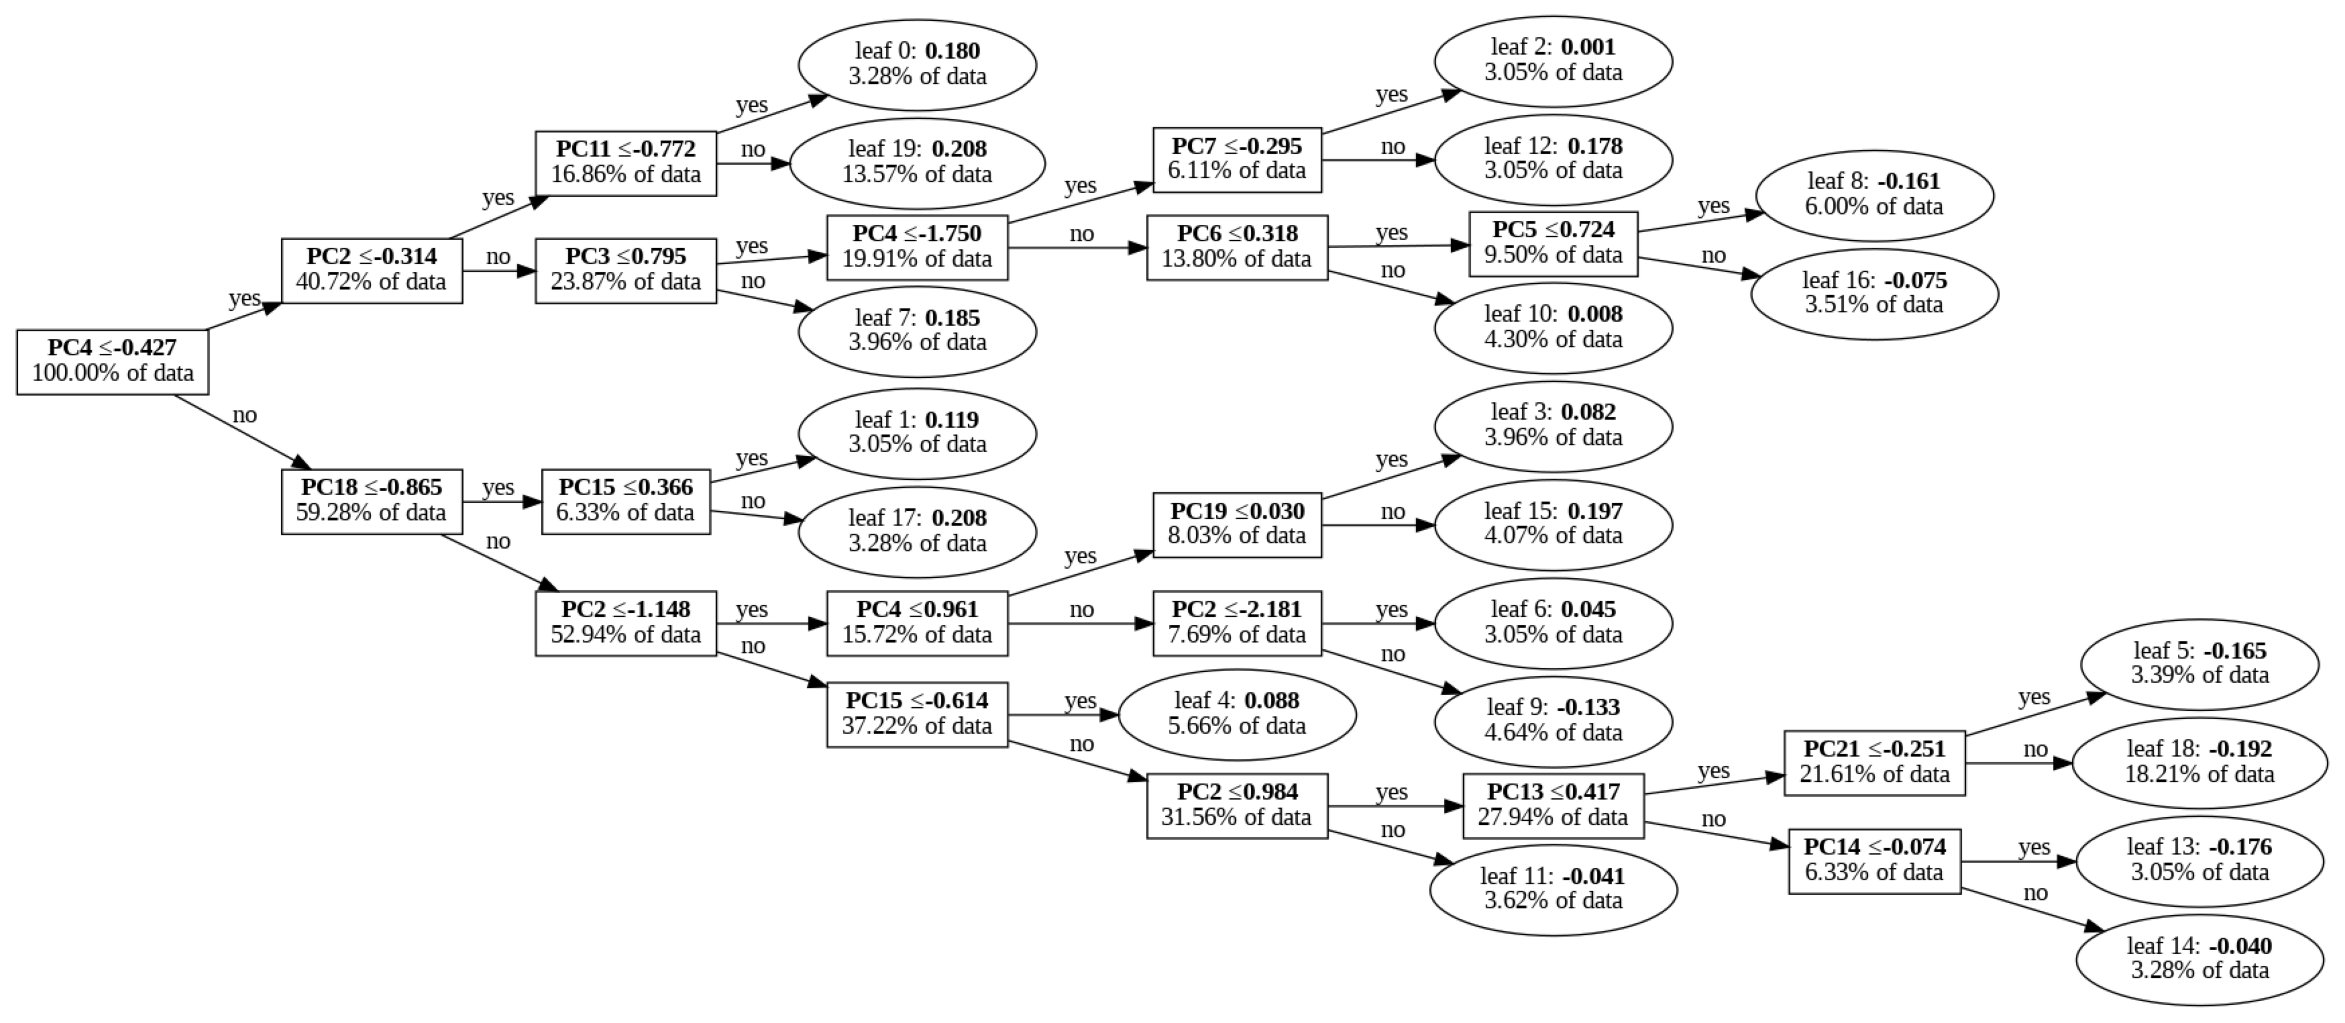

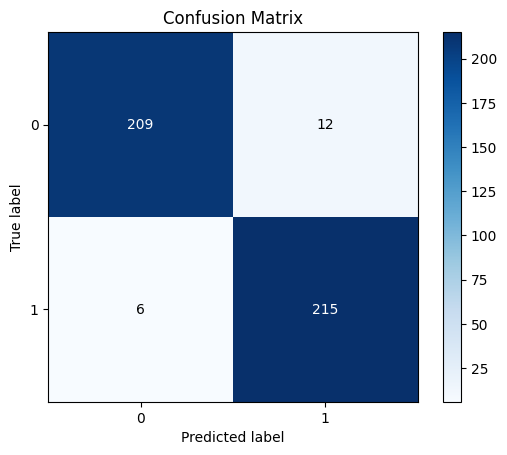

In [53]:
# Train the LightGBM model and pred on Test Set (PLEASE CLICK ON THE LINK RETURN IN THE RESPONSE TO SEE THE BETTER VISUALIZE AND DETAIL)
dataset = "https://raw.githubusercontent.com/nhanna1219/Closely_Customer_Classification/main/Preprocessed_Data.csv"
y_test, y_pred_test = TrainLightGBM(dataset,params,test_size=0.3,val_size=1/3)

https://app.neptune.ai/Light-GBM/CustomerLoyalty/e/CUS-143
[LightGBM] [Info] Number of positive: 778, number of negative: 771
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 1549, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502260 -> initscore=0.009038
[LightGBM] [Info] Start training from score 0.009038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

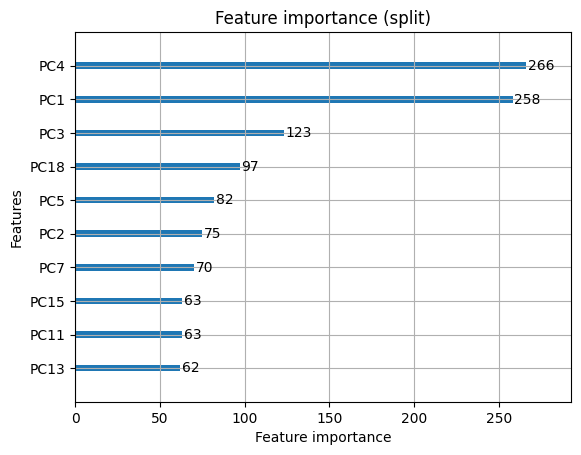

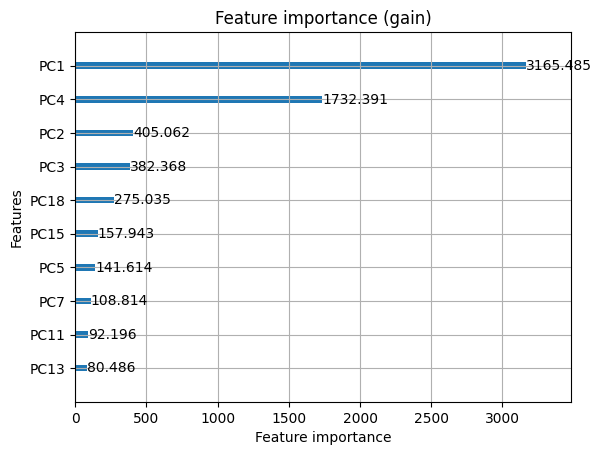

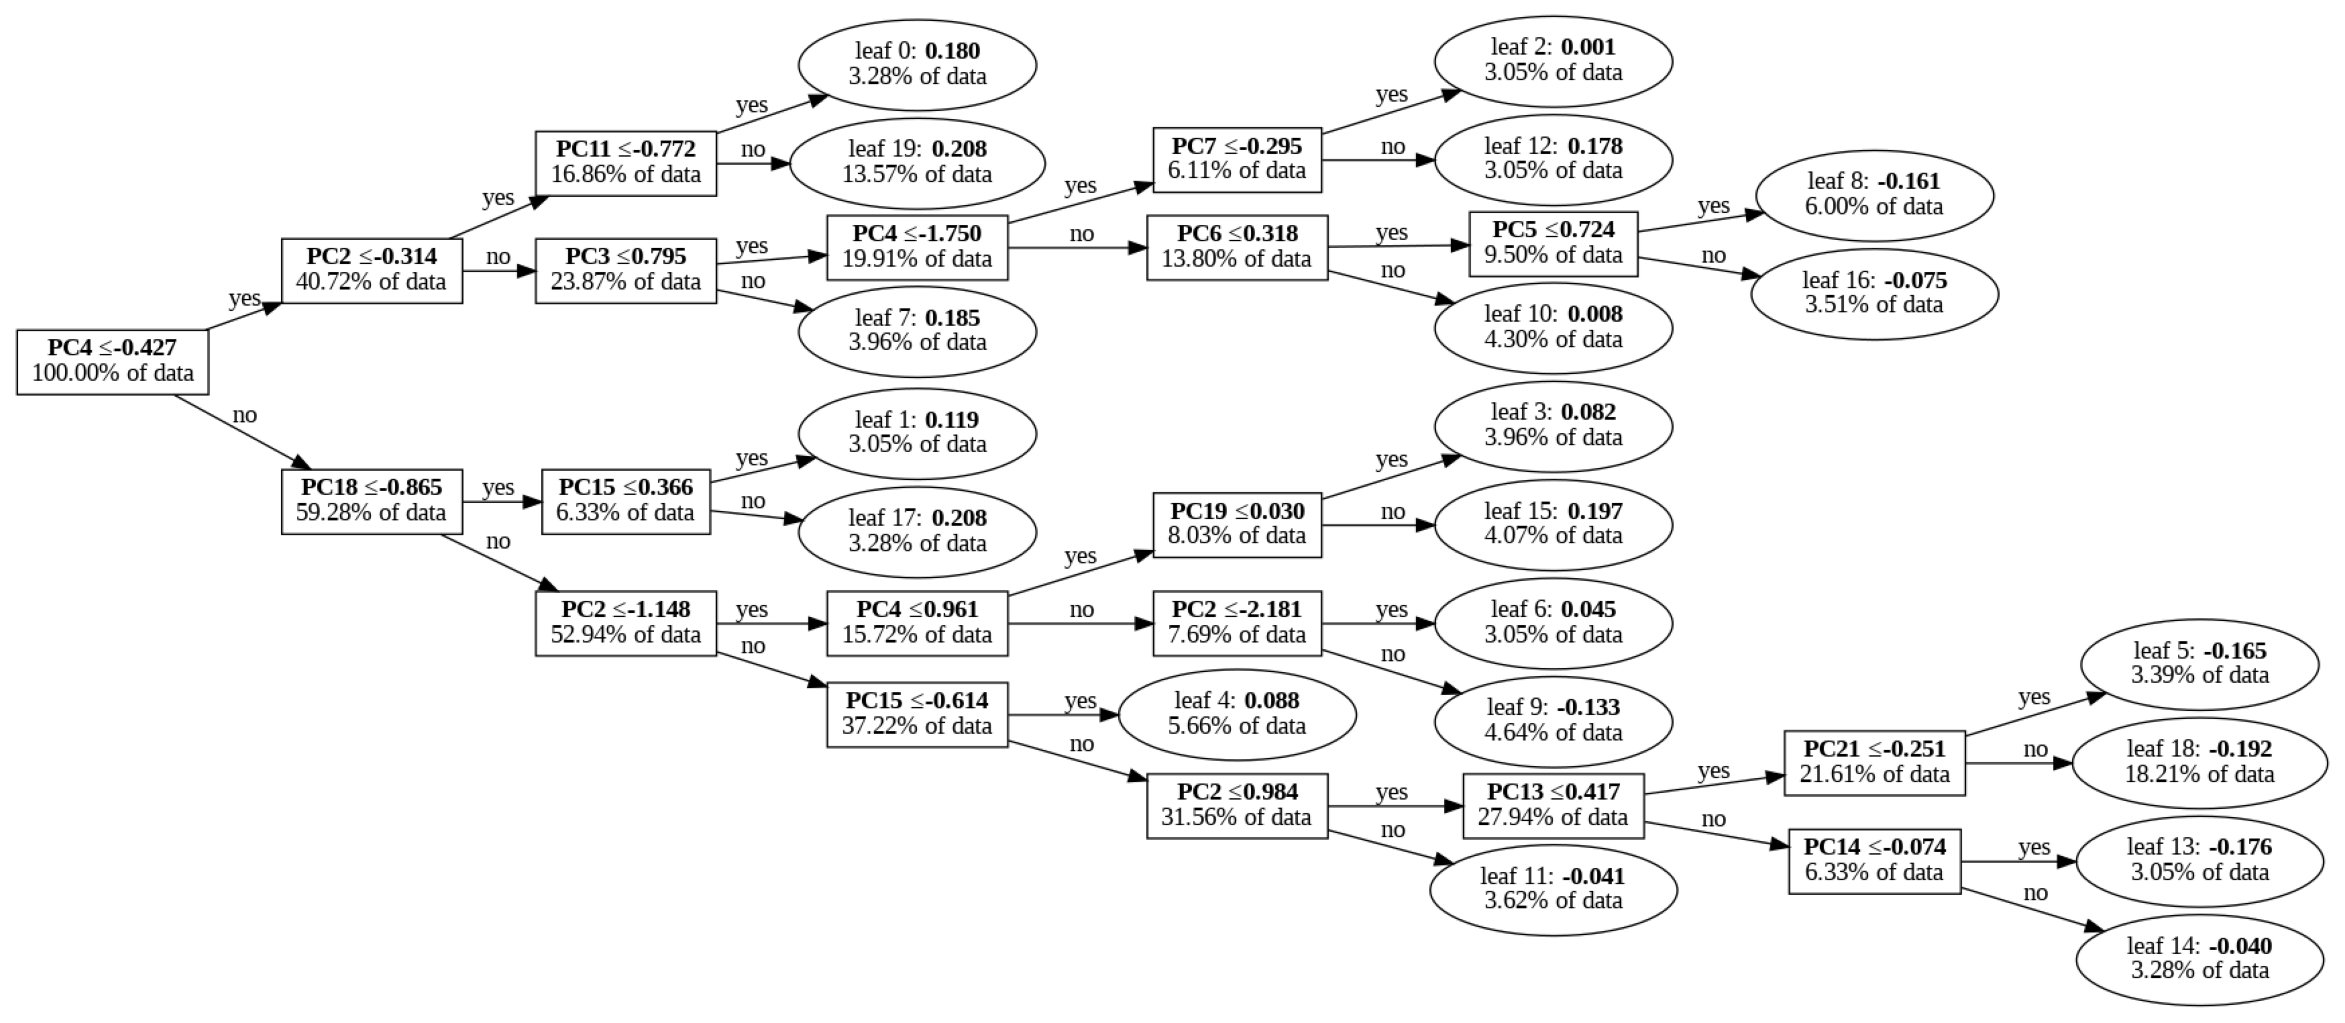

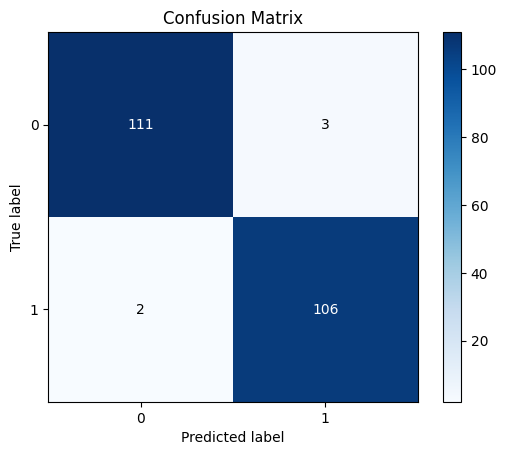

In [54]:
# Train the LightGBM model and pred on Test Set (PLEASE CLICK ON THE LINK RETURN IN THE RESPONSE TO SEE THE BETTER VISUALIZE AND DETAIL)
dataset = "https://raw.githubusercontent.com/nhanna1219/Closely_Customer_Classification/main/Preprocessed_Data.csv"
y_val, y_pred_val = TrainLightGBM(dataset,params,test_size=0.3,val_size=1/3, isPredTest=False)

>## ***3. Evaluate Model***

In [55]:
# Evaluate on Test Set
print('TEST SET:')
print(classification_report(y_test, y_pred_test))
print('``````````````````````````````````````````````````````')
print('VAL SET:')
# Evaluate on Val Set
print(classification_report(y_val, y_pred_val))

TEST SET:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       221
           1       0.95      0.97      0.96       221

    accuracy                           0.96       442
   macro avg       0.96      0.96      0.96       442
weighted avg       0.96      0.96      0.96       442

``````````````````````````````````````````````````````
VAL SET:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       114
           1       0.97      0.98      0.98       108

    accuracy                           0.98       222
   macro avg       0.98      0.98      0.98       222
weighted avg       0.98      0.98      0.98       222



# **8-1-1 DATASET**

>## ***1. Integrate with OPTUNA and Neptune to Find The Best Params For LightGBM***

In [56]:
# for i in range(3):
#   run = neptune.init_run(
#       project= PROJECT_NAME,
#       api_token= NEPTUNE_API_TOKEN,
#       name="train-cls",
#       tags=["lgbm-integration", "train", "cls", "notebook"],
#   )
#   neptune_callback = NeptuneCallback(run=run)

#   objective_8_1_1 = partial(objective, test_size=0.2, val_size=0.5)
#   neptune_callback = npt_utils.NeptuneCallback(run)
#   # study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="minimize")
#   study = optuna.create_study(directions=["minimize","maximize"])

#   study.optimize(objective_8_1_1, n_trials=200, show_progress_bar=True,callbacks=[neptune_callback])
#   run.stop()

In [57]:
# # Print Trials Information as Dataframe
# study.trials_dataframe()

In [58]:
trials_to_compare = ["CUS-104", "CUS-105", "CUS-106"]
GetBestTrials(trials_to_compare)

https://app.neptune.ai/Light-GBM/CustomerLoyalty/e/CUS-104

-----------------------------------
Trial ID: CUS-104
	Number: 159
	Params:
		lambda_l1: 0.005479370223208841
		lambda_l2: 0.0001672345112200015
		num_leaves: 162
		feature_fraction: 0.9225035494555749
		bagging_fraction: 0.8723783550659368
		bagging_freq: 2
		min_child_samples: 51
	Values:
		1: 0.07772852923704672
		2: 0.9798994974874372
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/Light-GBM/CustomerLoyalty/e/CUS-104/metadata
https://app.neptune.ai/Light-GBM/CustomerLoyalty/e/CUS-105

-----------------------------------
Trial ID: CUS-105
	Number: 156
	Params:
		lambda_l1: 3.718330163202492e-05
		lambda_l2: 0.004228366230953757
		num_leaves: 42
		feature_fraction: 0.8129751345833691
		bagging_fraction: 0.568750216237572
		bagging_freq: 6
		min_child_samples: 6
	Values:
		1: 0.05544436836141756
		2: 0.979

({'lambda_l1': 0.0020957860610432036,
  'lambda_l2': 7.722529228296979e-05,
  'num_leaves': 199,
  'feature_fraction': 0.8782255095588551,
  'bagging_fraction': 0.6746269268926641,
  'bagging_freq': 5,
  'min_child_samples': 23},
 <neptune.metadata_containers.run.Run at 0x7bc5b93328f0>)

> **Pick CUS-105 because it strikes the best balance between the two metrics.**









In [59]:
params, study, run = GetBestTrials(["CUS-105"])

https://app.neptune.ai/Light-GBM/CustomerLoyalty/e/CUS-105

-----------------------------------
Trial ID: CUS-105
	Number: 156
	Params:
		lambda_l1: 3.718330163202492e-05
		lambda_l2: 0.004228366230953757
		num_leaves: 42
		feature_fraction: 0.8129751345833691
		bagging_fraction: 0.568750216237572
		bagging_freq: 6
		min_child_samples: 6
	Values:
		1: 0.05544436836141756
		2: 0.9798994974874372


In [60]:
# plot_optimization_history: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study, target = lambda t: t.values[0]) #  Metric: Log Loss

/usr/local/lib/python3.10/dist-packages/optuna/visualization/_utils.py:67: UserWarning:

`target` is specified, but `target_name` is the default value, 'Objective Value'.



In [61]:
optuna.visualization.plot_optimization_history(study, target = lambda t: t.values[1]) #  Metric: Accuracy Score

In [62]:
# Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

>## ***2. Train and classify using the best params pick from above and apply to LightGBM model***

https://app.neptune.ai/Light-GBM/CustomerLoyalty/e/CUS-144
[LightGBM] [Info] Number of positive: 1000, number of negative: 991
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 1991, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502260 -> initscore=0.009041
[LightGBM] [Info] Start training from score 0.009041
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

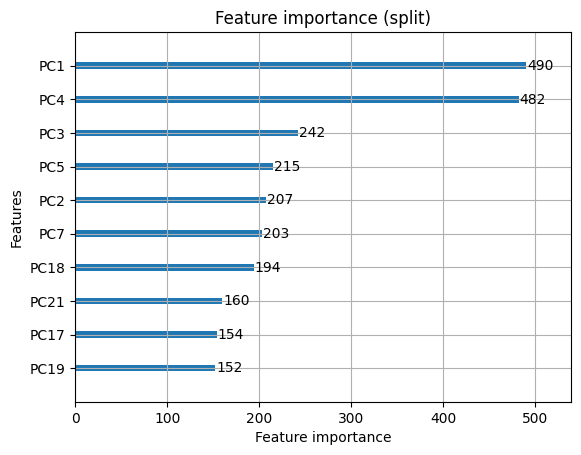

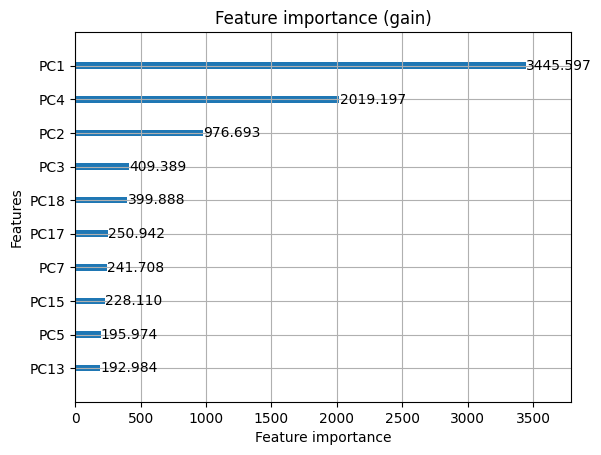

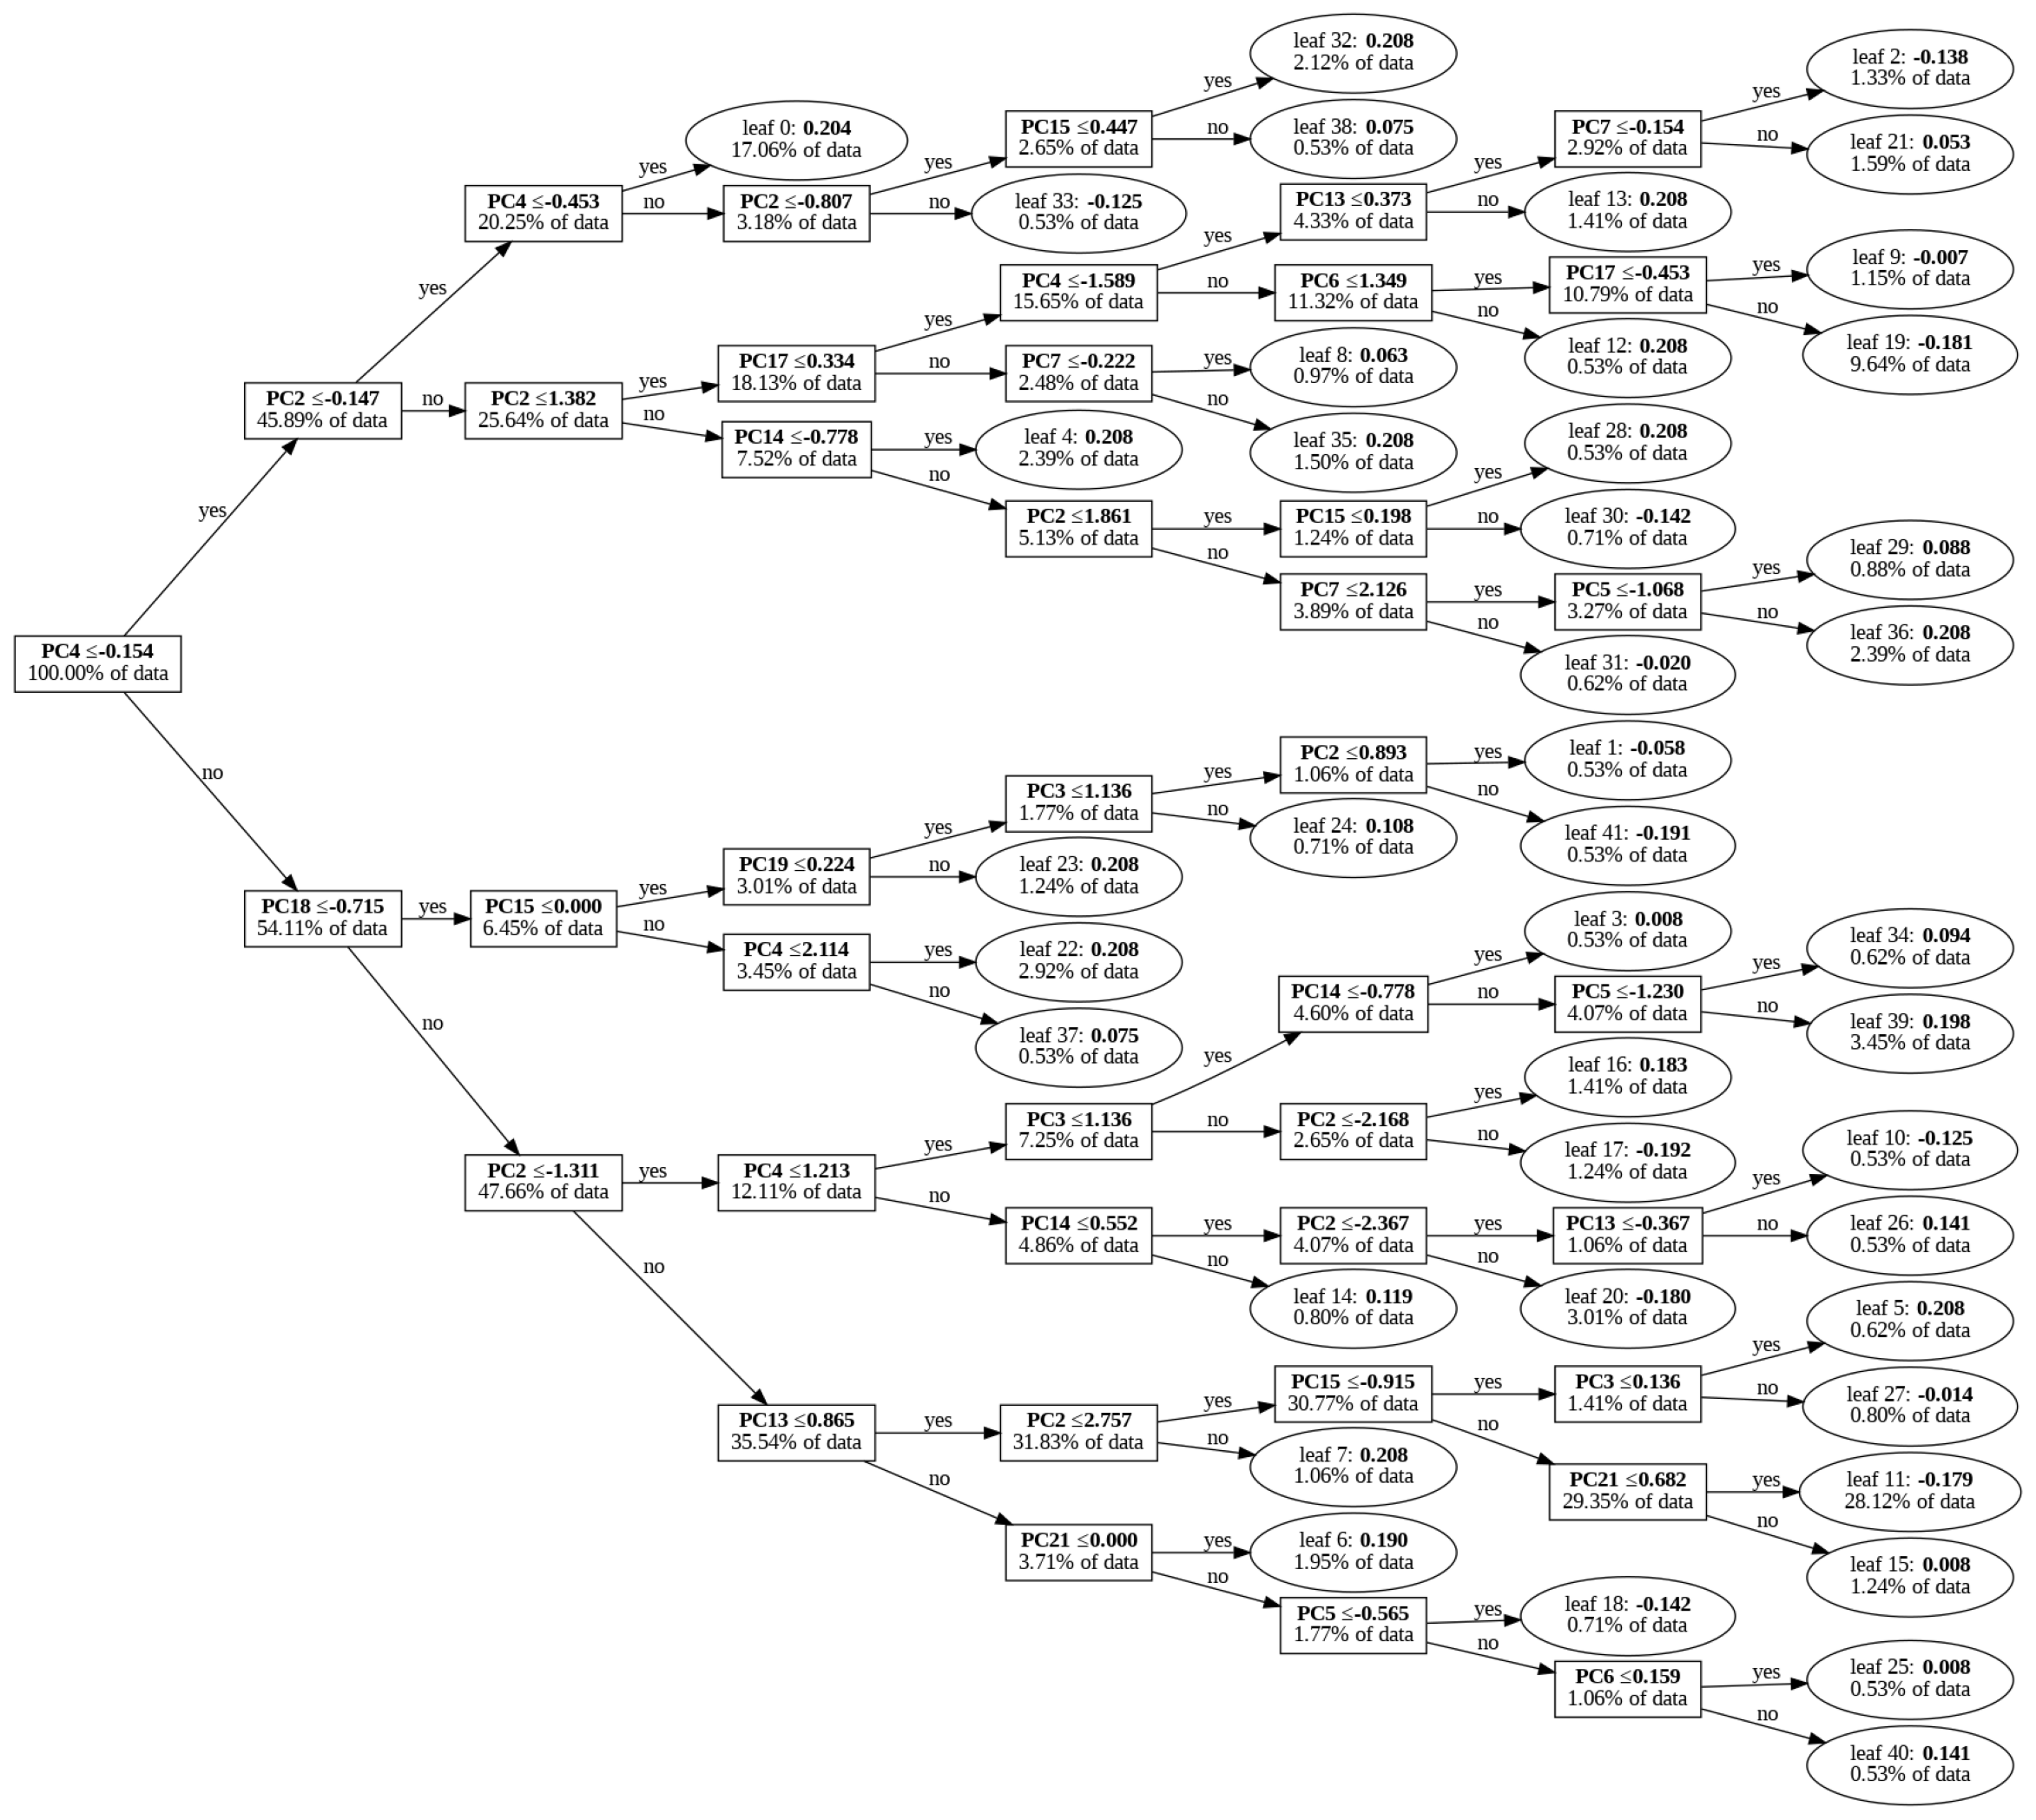

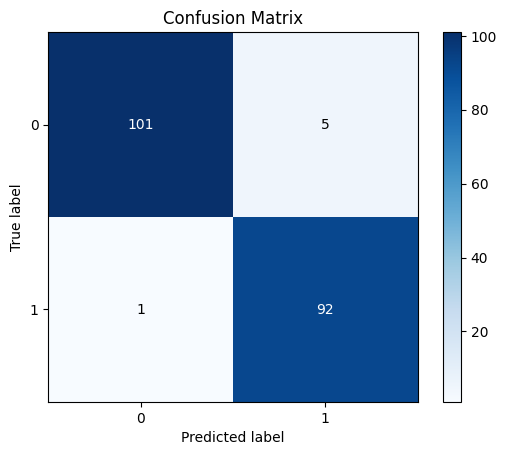

In [63]:
# Train the LightGBM model and pred on Test Set (PLEASE CLICK ON THE LINK RETURN IN THE RESPONSE TO SEE THE BETTER VISUALIZE AND DETAIL)
dataset = "https://raw.githubusercontent.com/nhanna1219/Closely_Customer_Classification/main/Preprocessed_Data.csv"
y_test, y_pred_test = TrainLightGBM(dataset,params,test_size=0.1,val_size=0.1)

https://app.neptune.ai/Light-GBM/CustomerLoyalty/e/CUS-145
[LightGBM] [Info] Number of positive: 892, number of negative: 878
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 1770, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503955 -> initscore=0.015820
[LightGBM] [Info] Start training from score 0.015820
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

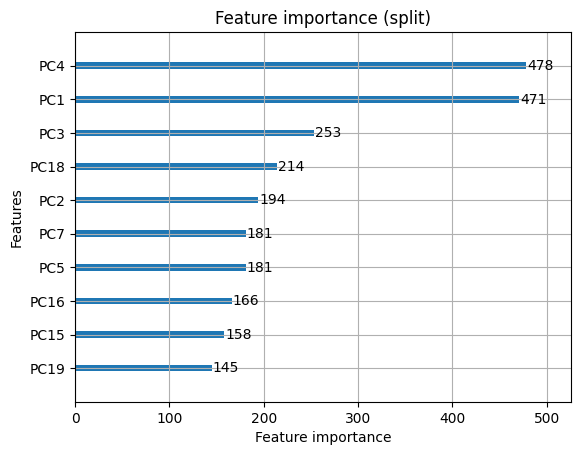

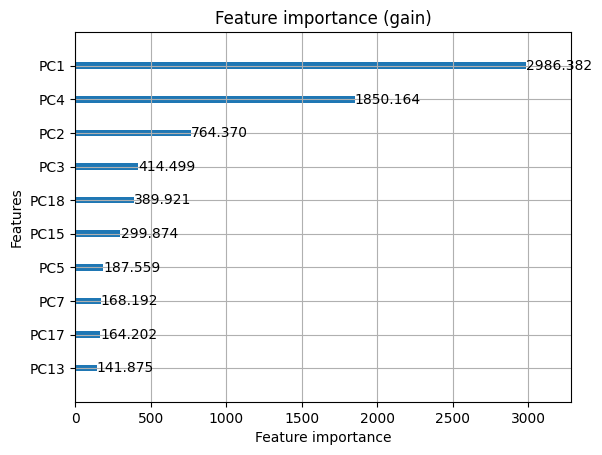

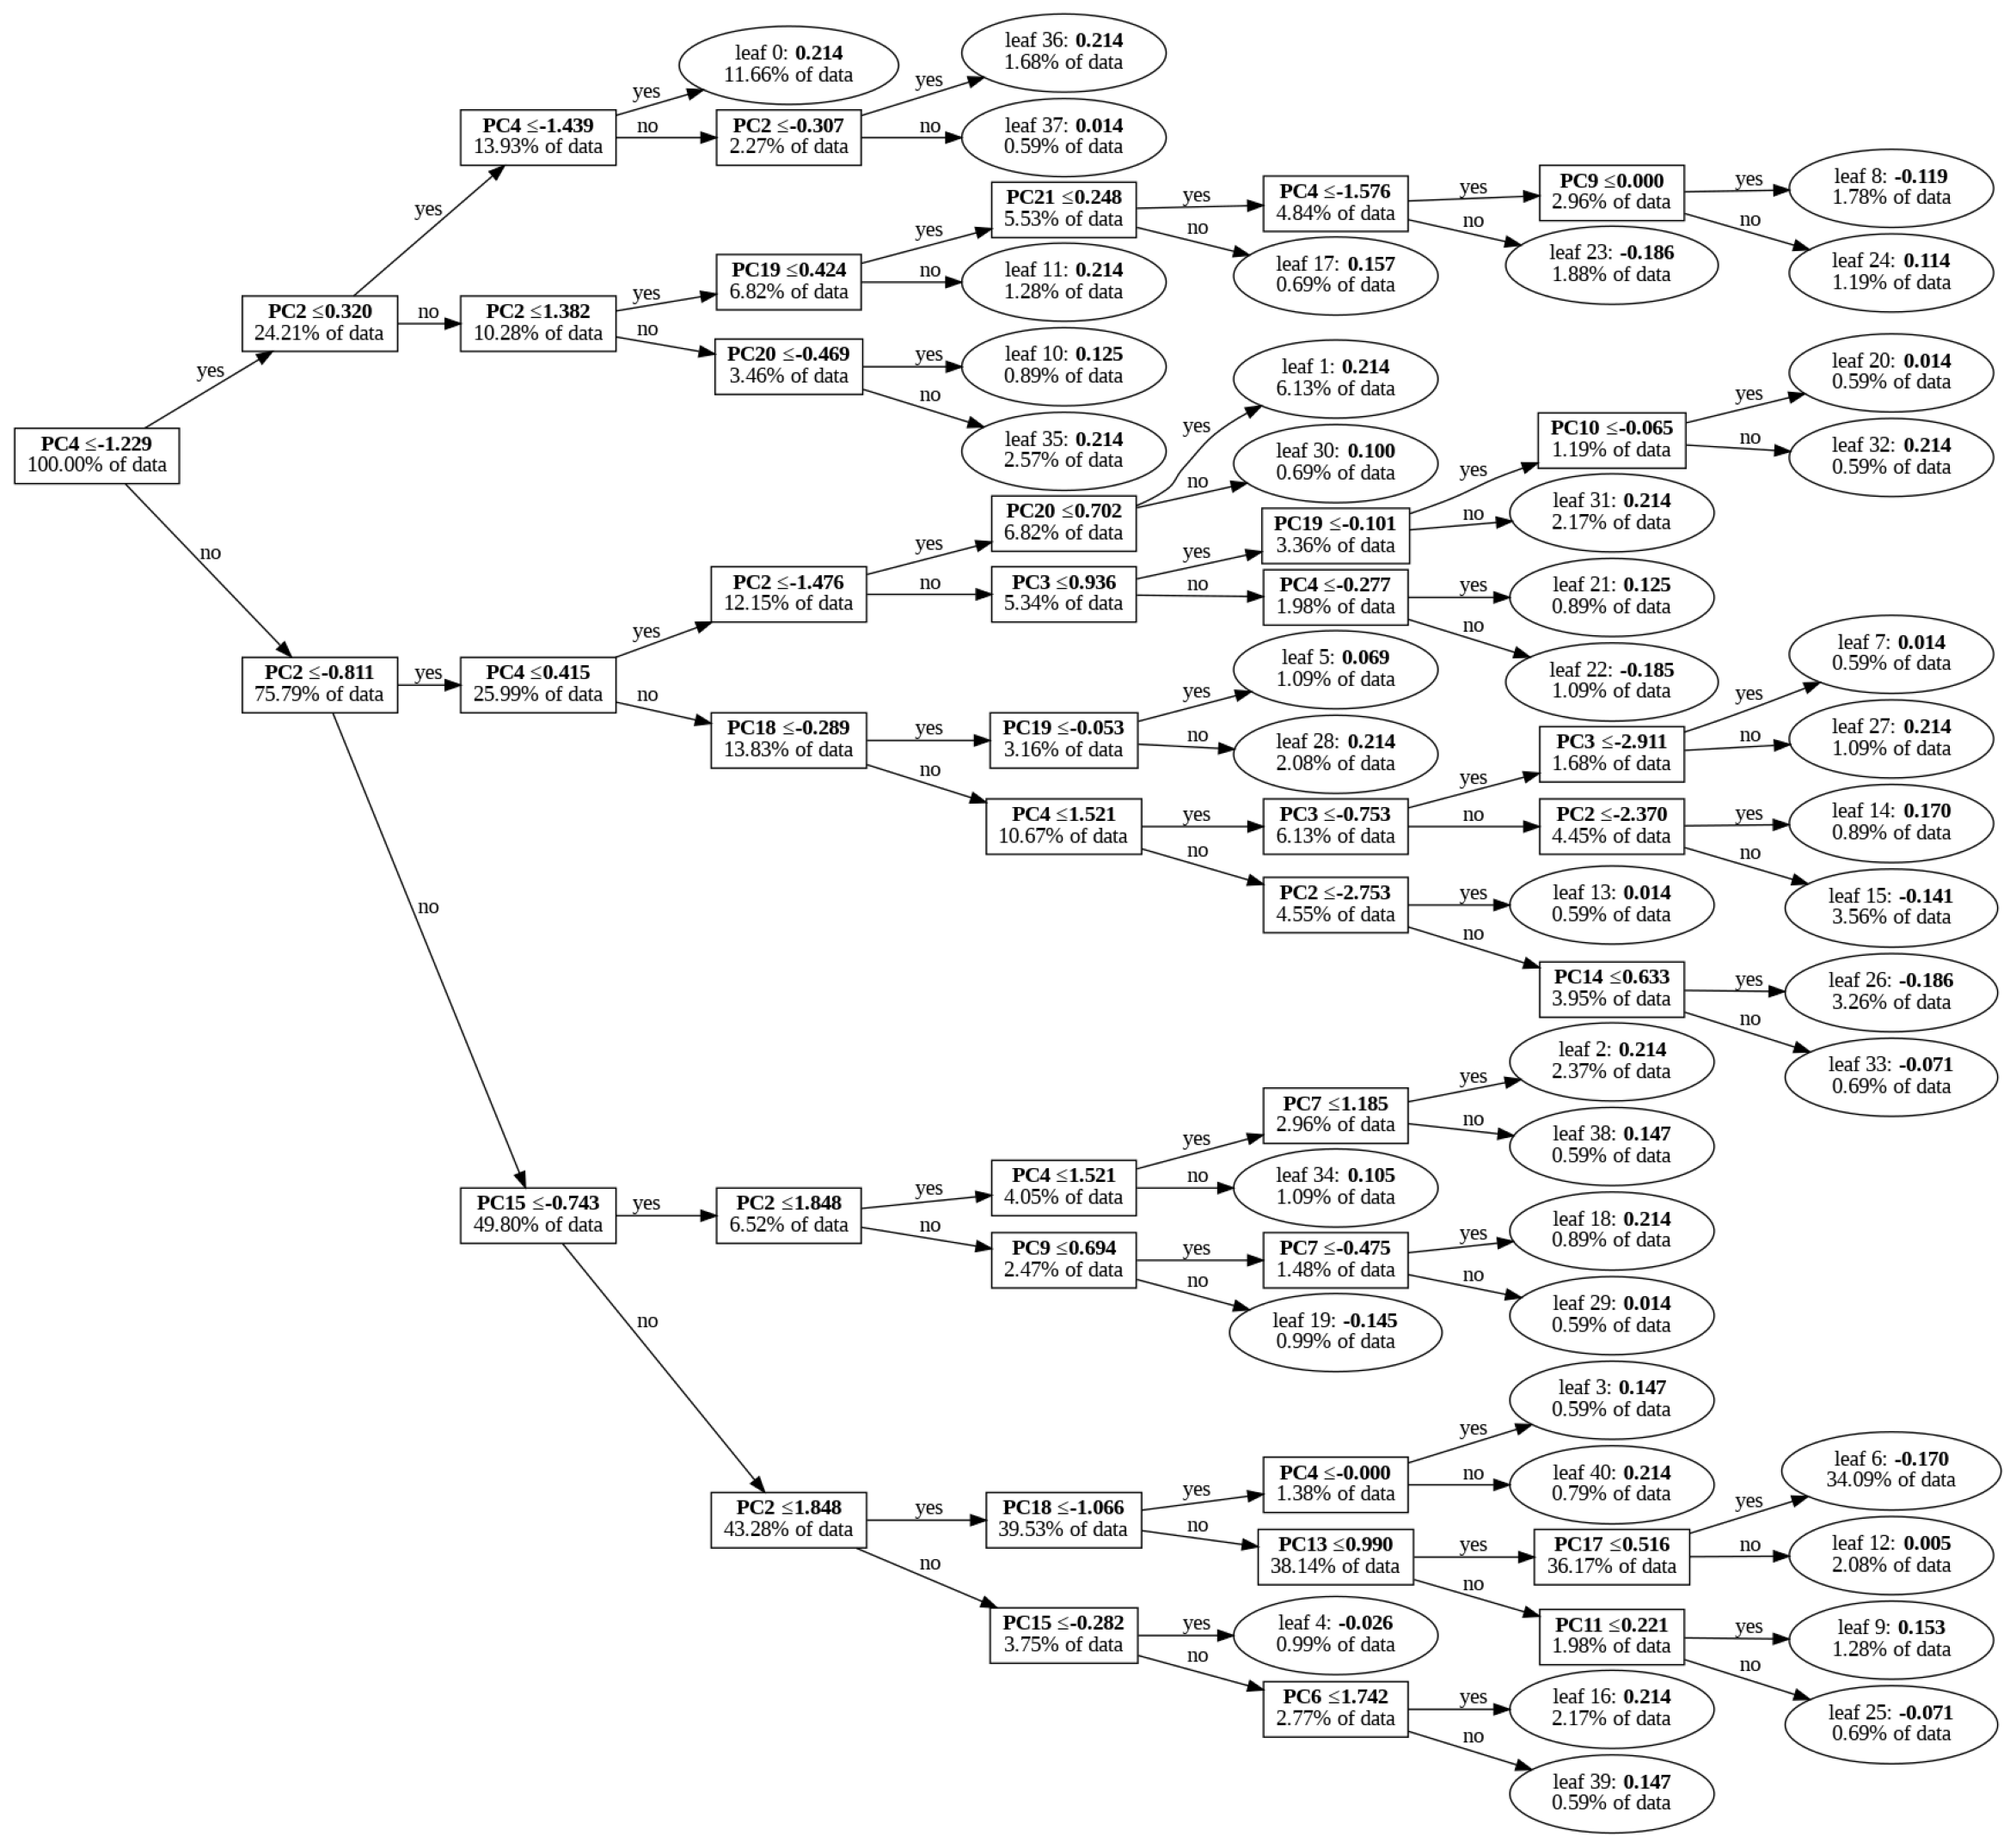

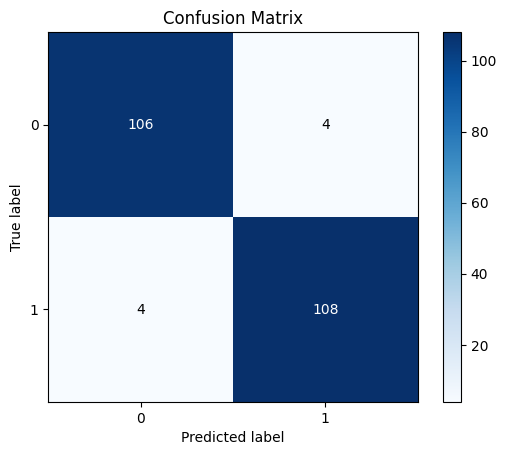

In [64]:
# Train the LightGBM model and pred on Val Set (PLEASE CLICK ON THE LINK RETURN IN THE RESPONSE TO SEE THE BETTER VISUALIZE AND DETAIL)
dataset = "https://raw.githubusercontent.com/nhanna1219/Closely_Customer_Classification/main/Preprocessed_Data.csv"
y_val, y_pred_val = TrainLightGBM(dataset,params,test_size=0.2,val_size=0.5,isPredTest=False)

>## ***3. Evaluate Model***

In [65]:
# Evaluate on Test Set
print('TEST SET:')
print(classification_report(y_test, y_pred_test))
print('``````````````````````````````````````````````````````')
print('VAL SET:')
# Evaluate on Val Set
print(classification_report(y_val, y_pred_val))

TEST SET:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       106
           1       0.95      0.99      0.97        93

    accuracy                           0.97       199
   macro avg       0.97      0.97      0.97       199
weighted avg       0.97      0.97      0.97       199

``````````````````````````````````````````````````````
VAL SET:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       110
           1       0.96      0.96      0.96       112

    accuracy                           0.96       222
   macro avg       0.96      0.96      0.96       222
weighted avg       0.96      0.96      0.96       222



# **TEST 2 MODEL (8-1-1, 7-2-1) ON FAKE DATASET**

In [66]:
# Read Fake Data
fake_df = pd.read_csv('https://raw.githubusercontent.com/nhanna1219/Closely_Customer_Classification/main/PCA_Fake_Data.csv', sep=",")

# Change "True" "False" label to 1, 0 respectively
fake_df['Is_Loyal'] = fake_df['Is_Loyal'].astype(int)

X_test = fake_df.drop(['Loyalty_Score','Is_Loyal'], axis=1)
y_test = fake_df['Is_Loyal']

https://app.neptune.ai/Light-GBM/CustomerLoyalty/e/CUS-146
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 7 operations to synchronize with Neptune. Do not kill this process.
All 7 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/Light-GBM/CustomerLoyalty/e/CUS-146/metadata


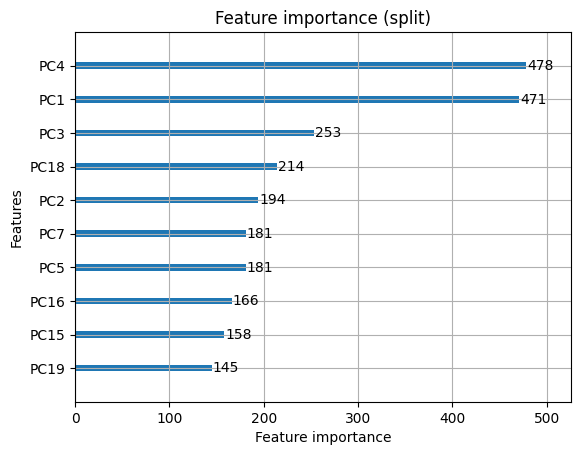

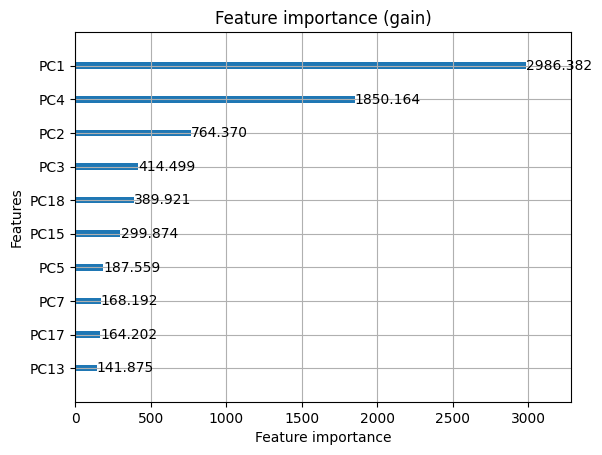

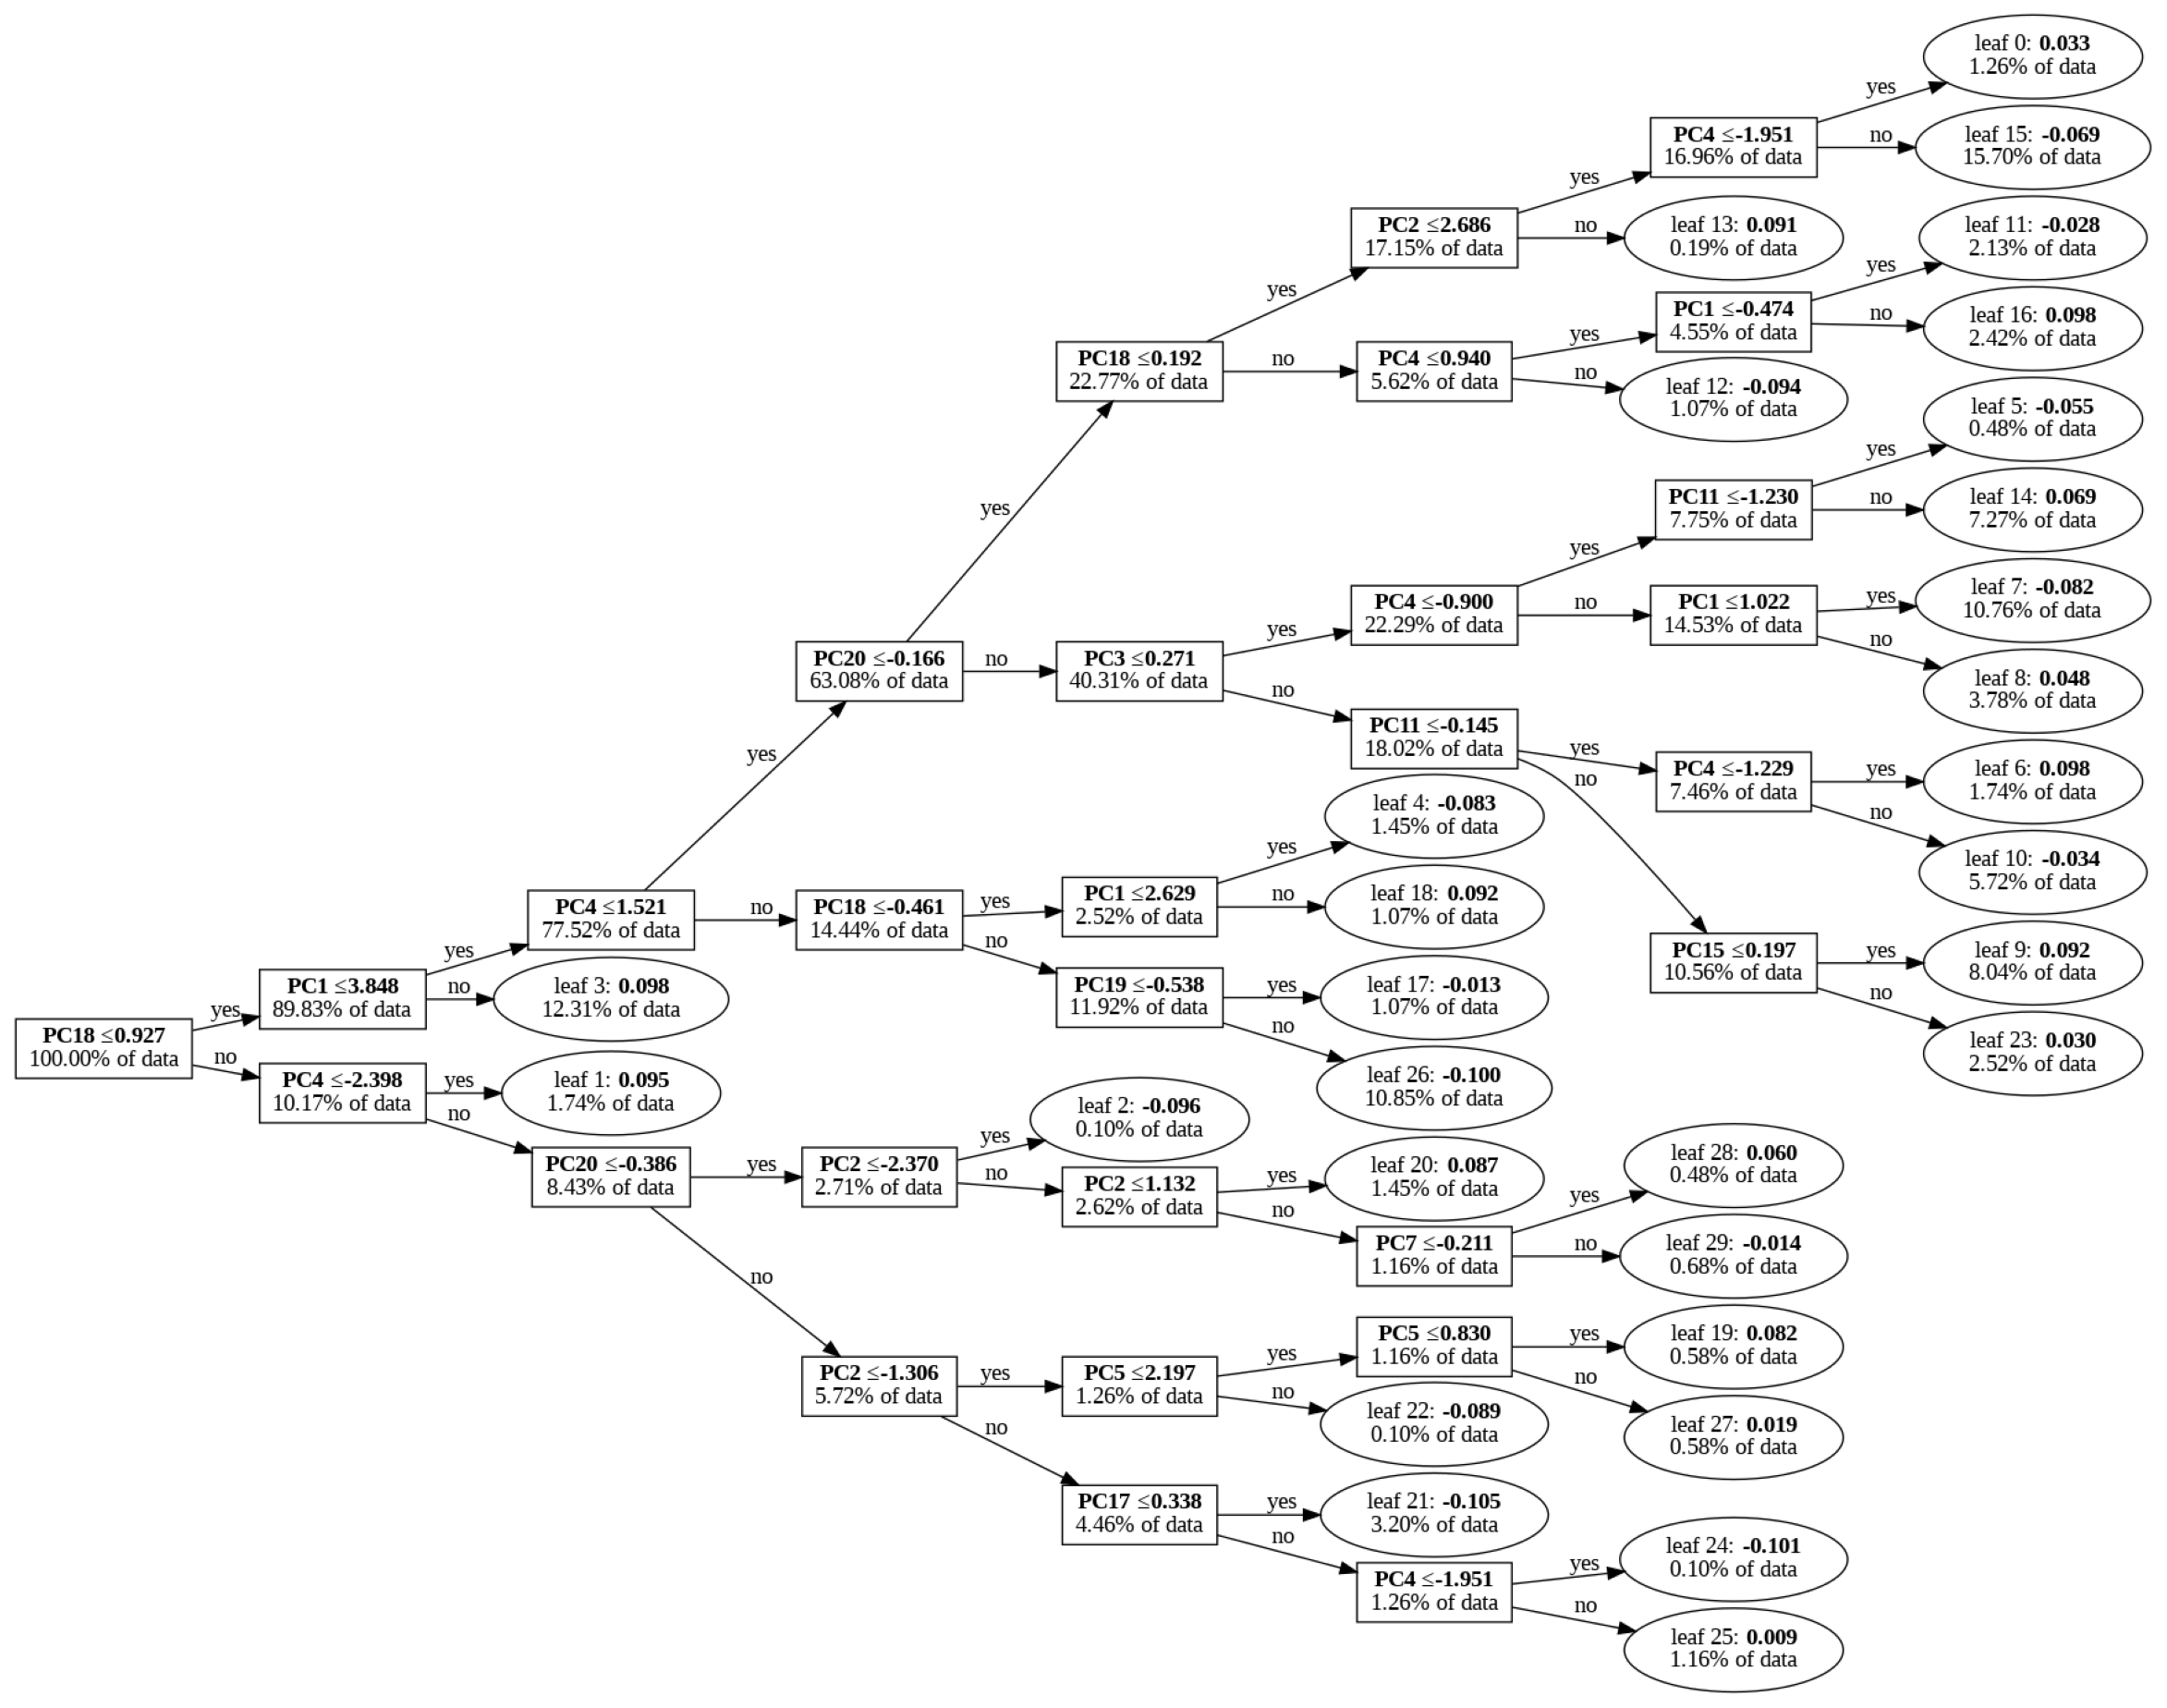

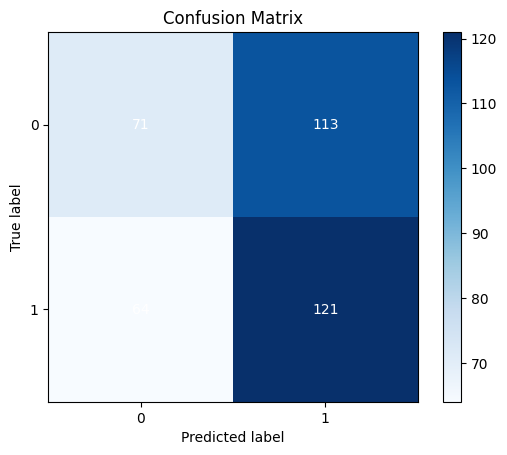

In [67]:
# Model 7-2-1
gbm_7_2_1 = lgb.Booster(model_file='/content/model_7-2-1')

run = neptune.init_run(
    project= PROJECT_NAME,
    api_token= NEPTUNE_API_TOKEN,
    name="train-cls",
    tags=["lgbm-integration", "train", "cls", "notebook"],
  )
neptune_callback = NeptuneCallback(run=run)

y_pred = gbm_7_2_1.predict(X_test,num_iteration=gbm_7_2_1.best_iteration)
binary_pred = (y_pred > 0.5).astype(int)

# Log summary metadata to the same run under the "lgbm_summary" namespace
run["lgbm_summary"] = create_booster_summary(
    booster=gbm_7_2_1,
    log_trees=True,
    list_trees=[gbm_7_2_1.best_iteration],
    log_confusion_matrix=True,
    y_pred=binary_pred,
    y_true=y_test,
)
run.stop()

In [68]:
print(classification_report(y_test, binary_pred))

              precision    recall  f1-score   support

           0       0.53      0.39      0.45       184
           1       0.52      0.65      0.58       185

    accuracy                           0.52       369
   macro avg       0.52      0.52      0.51       369
weighted avg       0.52      0.52      0.51       369



https://app.neptune.ai/Light-GBM/CustomerLoyalty/e/CUS-147
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 7 operations to synchronize with Neptune. Do not kill this process.
All 7 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/Light-GBM/CustomerLoyalty/e/CUS-147/metadata


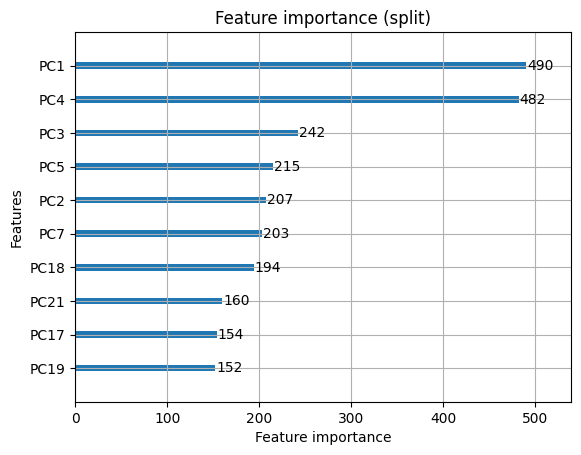

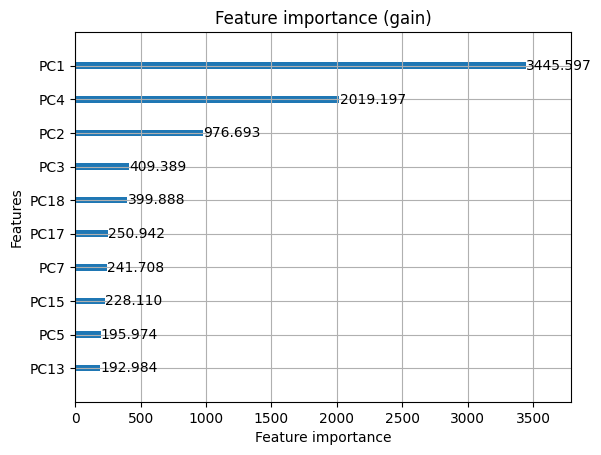

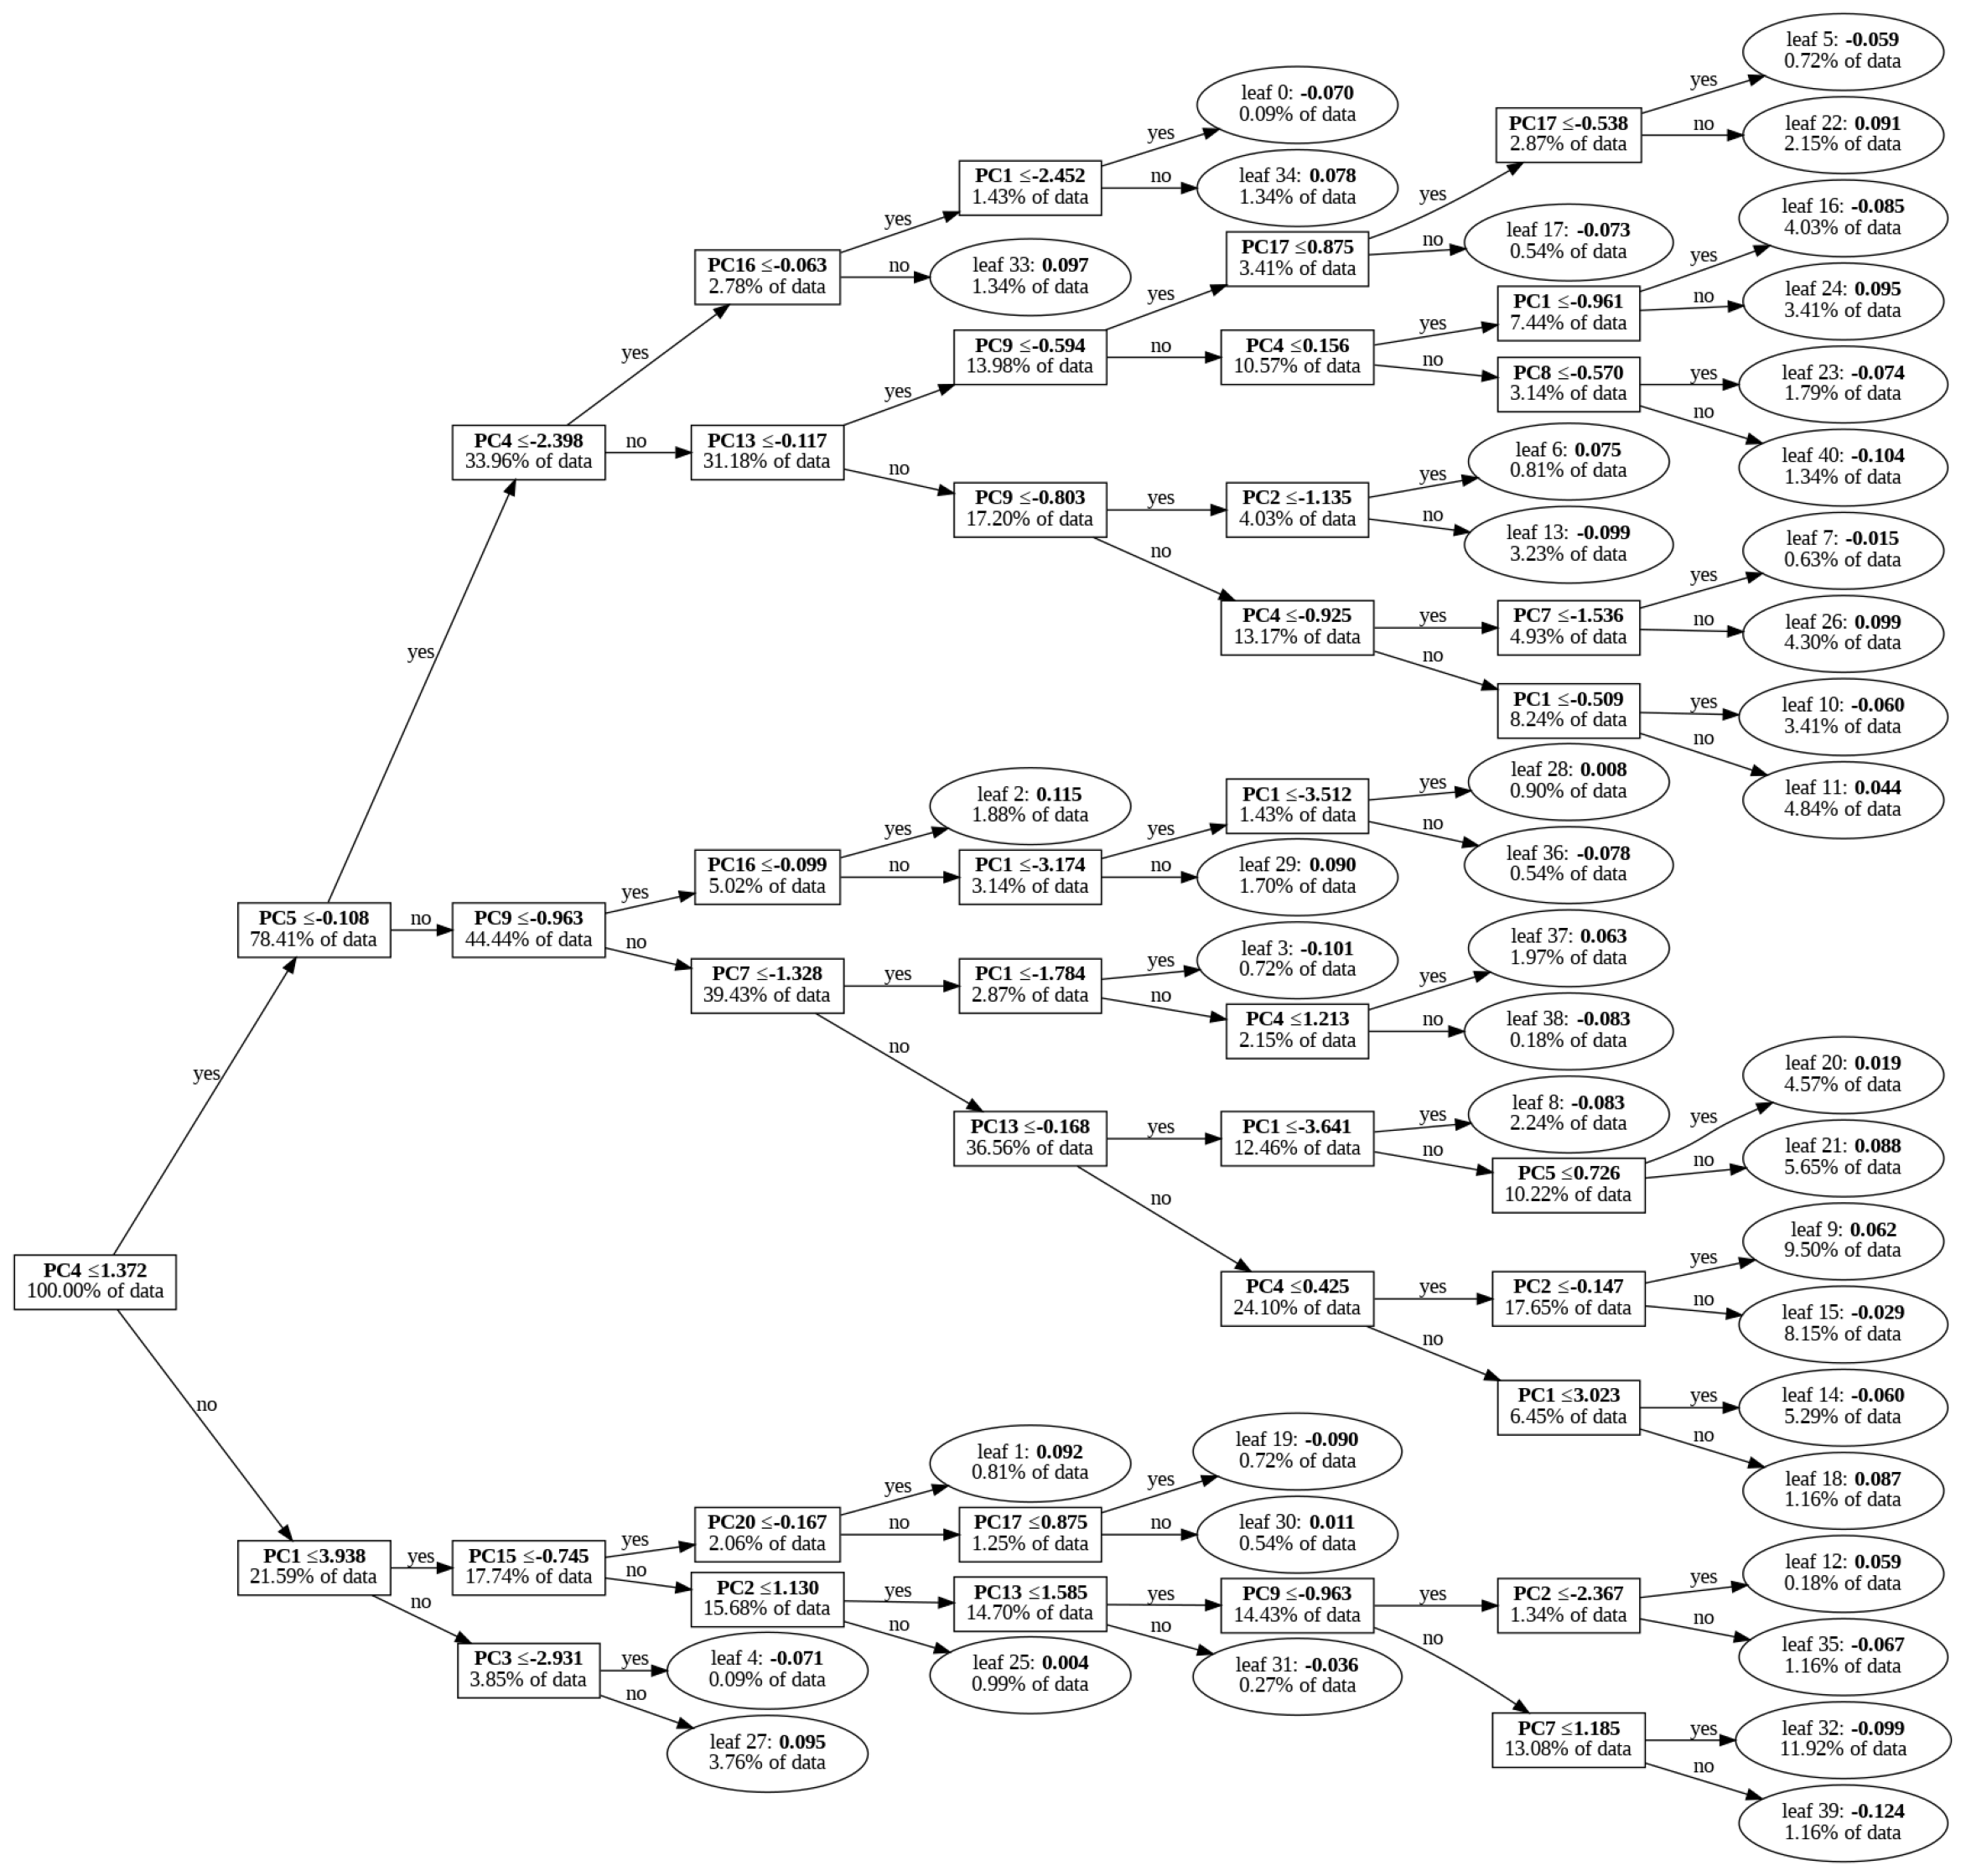

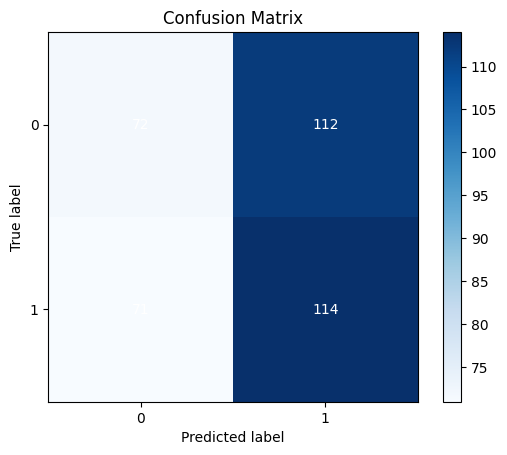

In [69]:
# Model 8-1-1
gbm_8_1_1 = lgb.Booster(model_file='/content/model_8-1-1')

run = neptune.init_run(
    project= PROJECT_NAME,
    api_token= NEPTUNE_API_TOKEN,
    name="train-cls",
    tags=["lgbm-integration", "train", "cls", "notebook"],
  )
neptune_callback = NeptuneCallback(run=run)

y_pred = gbm_8_1_1.predict(X_test,num_iteration=gbm_8_1_1.best_iteration)
binary_pred = (y_pred > 0.5).astype(int)

# Log summary metadata to the same run under the "lgbm_summary" namespace
run["lgbm_summary"] = create_booster_summary(
    booster=gbm_8_1_1,
    log_trees=True,
    list_trees=[gbm_8_1_1.best_iteration],
    log_confusion_matrix=True,
    y_pred=binary_pred,
    y_true=y_test,
)
run.stop()

In [70]:
print(classification_report(y_test, binary_pred))

              precision    recall  f1-score   support

           0       0.50      0.39      0.44       184
           1       0.50      0.62      0.55       185

    accuracy                           0.50       369
   macro avg       0.50      0.50      0.50       369
weighted avg       0.50      0.50      0.50       369

